#### Import required libs

In [38]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2
sys.path.append('../ADL4CV_project/')

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
import keras.backend as K
from keras.utils.generic_utils import Progbar
from functools import partial

import importlib.util
spec = importlib.util.spec_from_file_location("src.py", "/Users/jlee/Desktop/JONG/TUM/18W/Advanced_Deep_Learning_for_Computer_Vision/project/ADL4CV_project/src.py")
src = importlib.util.module_from_spec(spec)
spec.loader.exec_module(src)

K.set_image_dim_ordering('tf')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Path insert to use the load_datasets function in src.py
sys.path.insert(0, '/Users/jlee/Desktop/JONG/TUM/18W/\
Advanced_Deep_Learning_for_Computer_Vision/project/data')

#### Load the dataset
PAST is about the number of before frame. As we presented in 2nd presentation, our reference paper used 2 frames for input data. And we followed them. Also we augmented the training data by rotating the images. 

In [3]:
PAST = 2

In [4]:
train, val, test = src.load_datasets(past_frames=PAST)

Training data: (7500, 64, 64, 3)
Validation data: (1500, 64, 64, 3)
Test data: (1000, 64, 64, 3)


In [5]:
X_train, T_train, X_val, T_val, X_test, T_test = src.split_datasets(
            train[:2000], val, test, past_frames=PAST, augment=True)

Data augmentation.
Shape of training data:  (8000, 64, 64, 2) 
Shape of training truth:  (8000, 64, 64, 1) 
Shape of validation data:  (1500, 64, 64, 2) 
Shape of validation truth:  (1500, 64, 64, 1) 
Shape of test data:  (1000, 64, 64, 2) 
Shape of test truth:  (1000, 64, 64, 1)


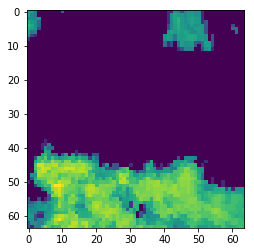

In [6]:
# Example of the our data
plt.imshow(X_train[0,:,:,0])

#### Functions to save images, and plot the curve

In [7]:
# The function is to save the predicted image for every nth iteration.
def sample_images(epoch, gan_test, gan_test_truth, generator, past_input, save_path):
    # epoch: the iteration number of training
    # gan_test: input data frames for testing
    # gan_test_truth: output data frame for testing
    # generator: trained generator model
    # past_input: the number of frames for input data
    # save_path: directory path to save 
    n = 5
    test_batch = gan_test[:n]
    test_truth = gan_test_truth[:n]
    gen_imgs = generator.predict(test_batch)
    plot_range = past_input 
    fig, axs = plt.subplots(n, plot_range+2, figsize=(16, 16))
    for i in range(n):
        vmax = np.max([np.max(test_batch[i]), np.max(test_truth[i])])
        vmin = 0
        for j in range(plot_range):
            im = axs[i,j].imshow(test_batch[i, :,:,j], vmax=vmax,vmin=vmin)
            axs[i,j].axis('off')
            src.colorbar(im)
            axs[i,j].set_title("Frame t"+str([-past_input+1+j if j < past_input-1 else ""][0]))
        im2 = axs[i,-2].imshow(test_truth[i, :,:,0], vmax=vmax, vmin=vmin)
        axs[i,-2].axis('off')
        src.colorbar(im2)                
        axs[i,-2].set_title("Frame t+1")
        im3 = axs[i,-1].imshow(gen_imgs[i, :,:,0], vmax=vmax, vmin=vmin)
        axs[i,-1].axis('off')
        src.colorbar(im3)
        axs[i,-1].set_title("Prediction t+1")
    fig.savefig(save_path+'epoch'+str(epoch)+'.png')
    plt.close()

In [8]:
# The function is to save the training curve for every nth iteration.
def plot_training_curves(log, epoch, name, wgan=False, gp=False):
    # log: a dictionary variable for losses
    # epoch: the iteration number of training
    # name: directory path to save 
    # wgan: is used for wgan(-gp) model or not
    # gp: is used for wgan-gp model or not
    total_g_loss = np.array(log["g_loss"])[:, 0]
    if gp == True and wgan == True : 
        total_d_loss = np.array(log["d_loss"])[:, 0]
    elif gp == False and wgan == True:
        total_d_loss = np.array(log["d_loss"])
    elif wgan == False :
        total_d_loss = np.array(log["d_loss"])[:, 0]
    smoothed_tgl = src.smooth(np.array(log["g_loss"])[:, 0])
    smoothed_tdl = src.smooth(total_d_loss)
    objective_loss = np.array(log["g_loss"])[:, 1]

    f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 2]})
    a0.plot(total_g_loss, alpha=0.3, c="b")
    a0.plot(smoothed_tgl, c="b", label="generator")
    a0.grid()
    if wgan:
        a0.plot(np.array(log["d_loss_real"]), c="g", label="real")
        a0.plot(np.array(log["d_loss_fake"]), c="r", label="fake")
    else:
        a0.plot(total_d_loss, alpha=0.3, c="orange")
        a0.plot(smoothed_tdl, c="orange", label="discriminator")
    a0.legend()
    a1.plot(objective_loss, alpha=0.9, c="green", label="L1 objective")
    a1.grid()
    a1.legend()
    f.text(0.5, 0, 'Iterations', ha='center', va='center')
    f.text(0, 0.5, 'Loss', ha='center', va='center', rotation='vertical')

    f.tight_layout()
    f.savefig(name+'epoch_'+str(epoch)+'_curves.png')

In [41]:
# The function is to save the image with real test dataset (only once after whole training)
def save_examples(path, test, predictions_dict, past, future, samples=0):
    # path: directory path to save 
    # test: test dataset
    # prediction_dict: predicted images by the generator
    # past: the number of frames for input data
    # future: the number of framse to predict
    # samples: indexes of test dataset to save
    fig, axs = plt.subplots(len(samples)*2,past+future, figsize=(32, 32))
    fig.subplots_adjust(wspace=0.3, hspace=0.0)
    for n in range(len(samples)):
        vmax = np.max(test[n,:,:,:past])
        vmin = 0
        print(test.shape)
        for i in range(past):
            im = axs[2*n,i].imshow(test[samples[n], :,:,i], vmax=vmax,vmin=vmin)
            axs[2*n,i].axis('off')
            axs[2*n,i].set_title(f"Past frame {i+1}")
            src.colorbar(im)
            im = axs[2*n+1,i].imshow(test[samples[n], :,:,i], vmax=vmax,vmin=vmin)
            axs[2*n+1,i].axis('off')
            axs[2*n+1,i].set_title(f"Past frame {i+1}")
            src.colorbar(im)
        for i in range(past,past+future):
            im = axs[2*n,i].imshow(predictions_dict[f"{i-past}"][samples[n], :,:,0], vmax=vmax, vmin=vmin)
            axs[2*n,i].axis('off')
            axs[2*n,i].set_title(f"Predicted frame {i-past+1}")
            src.colorbar(im)
            im = axs[2*n+1,i].imshow(test[samples[n], :,:,i], vmax=vmax, vmin=vmin)
            axs[2*n+1,i].axis('off')
            axs[2*n+1,i].set_title(f"Reference frame {i-past+1}")
            src.colorbar(im)
    fig.savefig(path+"_sequence_prediction.png")
    plt.close()

### WGAN
we changed our U-net architecture as symmetric one, and use same parameters except for loss function.
    
    reference sources:
* https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py
* https://myurasov.github.io/2017/09/24/wasserstein-gan-keras.html
* https://github.com/bobchennan/Wasserstein-GAN-Keras/blob/master/mnist_wacgan.py
* https://github.com/keras-team/keras-contrib/blob/master/examples/improved_wgan.py

#### Special functions for WGAN

In [10]:
# copied from 3rd reference
# Loss function for Wasserstein GAN (WGAN)
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [11]:
# copied from 4nd reference
# Additional loss function for improved Wasserstein GAN (WGAN-GP)
def gradient_penalty_loss(y_true, y_pred, averaged_samples, gradient_penalty_weight):
    """Calculates the gradient penalty loss for a batch of "averaged" samples.
    In Improved WGANs, the 1-Lipschitz constraint is enforced by adding a term to the loss function
    that penalizes the network if the gradient norm moves away from 1. However, it is impossible to evaluate
    this function at all points in the input space. The compromise used in the paper is to choose random points
    on the lines between real and generated samples, and check the gradients at these points. Note that it is the
    gradient w.r.t. the input averaged samples, not the weights of the discriminator, that we're penalizing!
    In order to evaluate the gradients, we must first run samples through the generator and evaluate the loss.
    Then we get the gradients of the discriminator w.r.t. the input averaged samples.
    The l2 norm and penalty can then be calculated for this gradient.
    Note that this loss function requires the original averaged samples as input, but Keras only supports passing
    y_true and y_pred to loss functions. To get around this, we make a partial() of the function with the
    averaged_samples argument, and use that for model training."""
    # first get the gradients:
    #   assuming: - that y_pred has dimensions (batch_size, 1)
    #             - averaged_samples has dimensions (batch_size, nbr_features)
    # gradients afterwards has dimension (batch_size, nbr_features), basically
    # a list of nbr_features-dimensional gradient vectors
    gradients = K.gradients(y_pred, averaged_samples)[0]
    # compute the euclidean norm by squaring ...
    gradients_sqr = K.square(gradients)
    #   ... summing over the rows ...
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
    #   ... and sqrt
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    # compute lambda * (1 - ||grad||)^2 still for each single sample
    gradient_penalty = gradient_penalty_weight * K.square(1 - gradient_l2_norm)
    # return the mean as loss over all the batch samples
    return K.mean(gradient_penalty)

In [12]:
# copied from 4nd reference
# Funtion is to merge the ground truth and generated image with random weights
class RandomWeightedAverage(keras.layers.Concatenate):
    """Takes a randomly-weighted average of two tensors. In geometric terms, this outputs a random point on the line
    between each pair of input points.
    Inheriting from _Merge is a little messy but it was the quickest solution I could think of.
    Improvements appreciated."""

    def _merge_function(self, inputs):
        weights = K.random_uniform((BATCH_SIZE, 1, 1, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])

#### Generator

In [13]:
# Unet is used for Generator
G = src.unet(X_train.shape[1:], dropout=0, batchnorm=True, kernel_size=4, feature_mult=1)
# G.summary()

#### Spatial Discriminator

In [14]:
# Convoluntional classifier is used for Discriminator
SD = src.spatial_discriminator(condition_shape=X_train.shape[1:], dropout = 0.25, batchnorm=True, wgan=True)
# SD.summary()

#### Parameter setting

In [15]:
# Set some parameters for training
# random seed
RND = 777
np.random.seed(RND)

BATCH_SIZE = 16
ITERATIONS = 50

# we train the discriminator 100 times for first 25 iterations (every start of 500 iterations)
# and normally train the discriminator 10 times for each iteration
INIT_D_ITERS = 100
D_ITERS = 10

GRADIENT_PENALTY_WEIGHT = 10
PATH = '/Users/jlee/Desktop/JONG/TUM/18W/Advanced_Deep_Learning_for_Computer_Vision/project/results/wgan_results/test/'

#### Make models to train

In [16]:
# freeze the discriminator's weights
for l in SD.layers:
    l.trainable = False
SD.trainable = False

# make a whole network to train the generator with freezed discriminator
condition = keras.layers.Input(shape=X_train.shape[1:], name='input_condition_')
generated = G(condition)
output_is_fake = SD(inputs = [condition, generated])
DG = keras.models.Model(inputs=[condition], outputs=[generated, output_is_fake])

# keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9)
# in our reference code, they used Adam. But we found that RMSprop provides more good results for our case.
DG.compile(optimizer=keras.optimizers.RMSprop(lr=0.00005), 
           loss = [src.custom_loss(loss='l1'), wasserstein_loss],
           loss_weights = [0,1]
)
DG.summary()

***Using L1 loss.***
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_condition_ (InputLayer)   (None, 64, 64, 2)    0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 64, 64, 1)    153857      input_condition_[0][0]           
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            176049      input_condition_[0][0]           
                                                                 model[1][0]                      
Total params: 329,906
Trainable params: 153,345
Non-trainable params: 176,561
__________________________________________________________________________________________________


In [17]:
# unfreeze the discriminator's weights and freeze 
for l in SD.layers:
    l.trainable = True
for l in G.layers:
    l.trainable = False
SD.trainable = True
G.trainable = False

# make a network to train the discriminator with gradient penalty loss.
real_samples = keras.layers.Input(shape=T_train.shape[1:])
condition = keras.layers.Input(shape=X_train.shape[1:])
generated = G(condition)
d_output_generated = SD([condition, generated])
d_output_real = SD([condition, real_samples])

averaged_samples = RandomWeightedAverage()([real_samples, generated])
averaged_samples_out = SD([condition, averaged_samples])

partial_gp_loss = partial(gradient_penalty_loss,
                          averaged_samples=averaged_samples,
                          gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
partial_gp_loss.__name__ = 'gradient_penalty' 

D = keras.models.Model(inputs=[condition, real_samples],
          outputs=[d_output_real,
                   d_output_generated,
                   averaged_samples_out])

# keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9)
# in our reference code, they used Adam. But we found that RMSprop provides more good results for our case.
D.compile(optimizer=keras.optimizers.RMSprop(lr=0.00005),
          loss=[wasserstein_loss, wasserstein_loss, partial_gp_loss])

D.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 64, 64, 2)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 64, 64, 1)    153857      input_5[0][0]                    
__________________________________________________________________________________________________
random_weighted_average (Random (16, 64, 64, 1)      0           input_4[0][0]                    
                                                                 model[2][0]                      
__________

#### Training

In [18]:
# ignore the warning message (because there are huge messages when you freeze weights)
import warnings; warnings.simplefilter('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

progress_bar = Progbar(target=ITERATIONS)

log = {"g_loss":[],
       "d_loss":[],
       "d_loss_gp":[],
       "d_loss_real":[],
       "d_loss_fake":[],
       "d_loss_wgan":[]}

positive_y = np.ones((BATCH_SIZE, 1), dtype=np.float32)
negative_y = -positive_y
dummy_y = np.zeros((BATCH_SIZE, 1), dtype=np.float32)

50/50 [==============================] - 955s 19s/step - d_loss_r: -4.5849 - d_loss_f: -25.0849 - g_loss: 16.9324


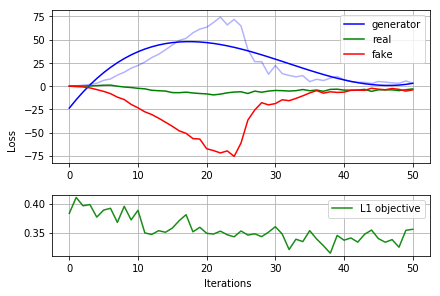

In [19]:
# Training
for it in range(ITERATIONS+1):

    if len(log['d_loss_real']) > 5:
        progress_bar.update(
            it,
            values=[ # avg of 5 most recent
                    ('d_loss_r', np.mean(log['d_loss_real'][-5:], axis=0)),
                    ('d_loss_f', np.mean(log['d_loss_fake'][-5:], axis=0)),
                    ('g_loss', np.mean(log['g_loss'][-5:],axis=0))
            ]
        )
        
    else:
        progress_bar.update(it)
        
    # 1: train D on real+generated images

    if (it % 500) < 25 or it % 250 == 0: # 25 times in 1000, every 500th
        d_iters = INIT_D_ITERS
    else:
        d_iters = D_ITERS
     
    # freeze G
    for l in SD.layers:
        l.trainable = True
    for l in G.layers:
        l.trainable = False
    SD.trainable = True
    G.trainable = False

    for d_it in range(d_iters):

        # random samples from training dataset
        index = np.random.choice(len(X_train), BATCH_SIZE, replace=False)
        base_images = X_train[index]
        real_images = T_train[index]

        # maximize D output on reals === minimize -1*(D(real))
        # minimize D output on fakes === minimize 1*(D(fake))
        D_loss = D.train_on_batch([base_images, real_images], [negative_y, positive_y, dummy_y])

    # 2: train D(G) 
    
    # freeze D
    for l in SD.layers:
        l.trainable = False
    for l in G.layers:
        l.trainable = True
    SD.trainable = False
    G.trainable = True
        
    # random samples from training dataset
    index = np.random.choice(len(X_train), BATCH_SIZE, replace=False)
    base_images = X_train[index]
    real_images = T_train[index]

    # maximize D output on fakes === minimize -1*(D(fake))
    DG_loss = DG.train_on_batch(base_images, [real_images, negative_y])
    
    # store the losses 
    log['g_loss'].append(DG_loss)
    log['d_loss_real'].append(D_loss[1])
    log['d_loss_fake'].append(D_loss[2])
    log['d_loss'].append(D_loss)
    log['d_loss_gp'].append(D_loss[3])
    log['d_loss_wgan'].append(-1 * D_loss[1] + D_loss[2])
    
    if it%100 == 0:
        # every 100 iterations, save the predicted image
        sample_images(it, X_test, T_test, G, PAST, PATH)
    if it != 0 and it % 50 == 0:
        # every 50 iterations, save the training curve
        plot_training_curves(log, it, PATH, wgan=True, gp=True)

#### Save the results

In [20]:
# Save the models' weights
G.save_weights(PATH+'G_model.h5')
SD.save_weights(PATH+'SD_model.h5')
DG.save_weights(PATH+'DG_model.h5')

In [21]:
# Save the losses
np.save(PATH+"_log",log)

#### Evaluate the results

In [22]:
# Make predicted images
G_imgs = G.predict(X_test)

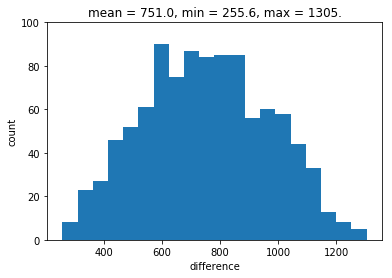

In [23]:
# compare the difference with predicted image and ground truth image
error_images, error_vals, error_means = src.error_distribution(T_test, G_imgs, metric="difference")

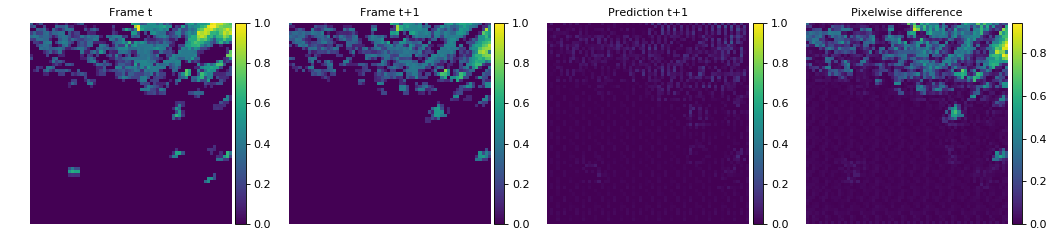

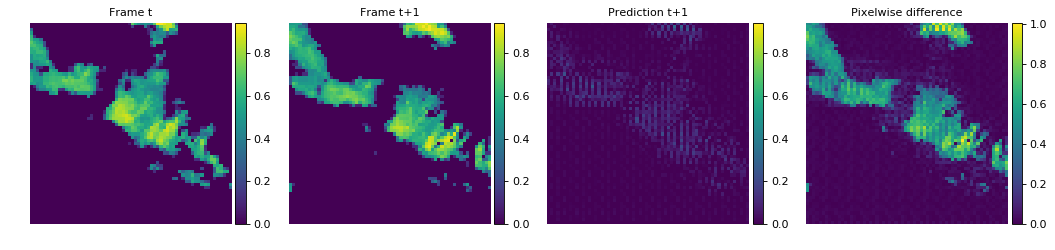

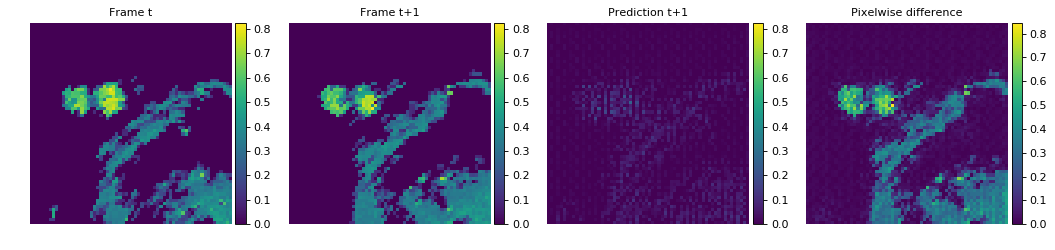

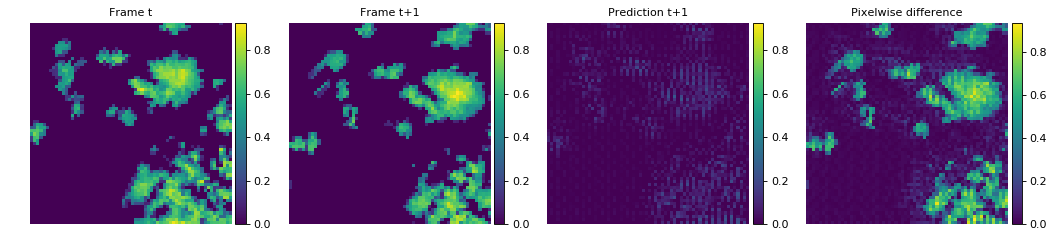

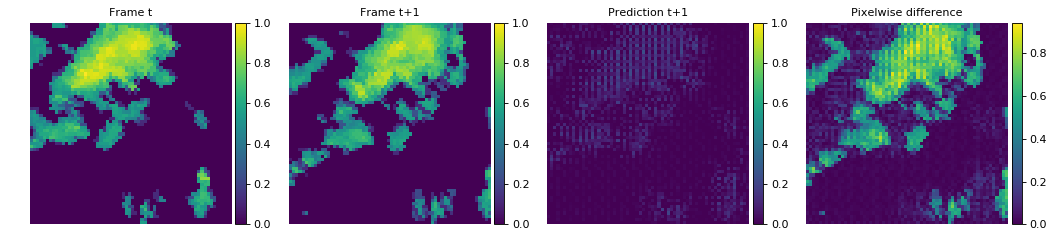

In [24]:
# show first 5 images in test dataset with predicted image
src.result_plotter(range(5), (X_test[:,:,:,0], T_test[:,:,:,0], G_imgs[:,:,:,0], error_images[:,:,:,0]), save=False)

#### Sequential prediction for future frames

In [25]:
# if the prediction is True with load_datasets function, it load test dataset and it contains 20 frames
past = 2
sequence_test = src.load_datasets(prediction=True)
sequence_test = src.augment_data(sequence_test[:100])
sequence_test.shape

Test data: (1000, 64, 64, 20)


(400, 64, 64, 20)

In [26]:
predictions = {}
past_frames = sequence_test[...,0:past]
test_truth = sequence_test[...,past:past+1]
gen = G

In [27]:
# predict the future frames (if past is 2, then 18 future frames will predicted) (ex. past: 3 --> 17)
for t in range(sequence_test.shape[-1] - past):
    future = gen.predict(past_frames, batch_size=64)
    predictions[f"{t}"] = future
    past_frames = np.concatenate((past_frames[:,:,:,1:], predictions[f"{t}"]), axis=-1)
    test_truth = sequence_test[...,past+1+t:past+2+t]

In [46]:
# Save the predicted image 
save_examples(PATH, sequence_test, predictions, past, future=5, samples=[33,46,54]) # 33, 46, 54

(400, 64, 64, 20)
(400, 64, 64, 20)
(400, 64, 64, 20)


#### Calculation for scores and correlation values

In [29]:
# load the dataset to calculate the scores and correlation
norms = np.load(sys.path[0]+"/5min_long_pred_norms_compressed.npz")["arr_1"]

In [30]:
# *4 bc of augmentaion (it concats the frames so the 0th 1000th 2000th and 3000th are the same sample just rotated)
test_norms = list(norms)*4

In [31]:
# renormalize test samples
renormalized_test = np.array([sample * np.array(test_norms)[i] for i, sample in enumerate(sequence_test)])
renormalized_predictions = np.transpose((np.array([[sample * np.array(test_norms)[i] for i, sample in enumerate(predictions[key])] for key in predictions.keys()])[:,:,:,:,0]), (1,2,3,0))

In [32]:
renormalized_predictions.shape

(400, 64, 64, 18)

In [33]:
thresholds = [10, 50, 100]
scores = {}
for t in range(renormalized_predictions.shape[-1]): # loop over the predictions (4)
    for s in thresholds: # make a dict entry for each threshold score
        scores[f"pred_{t+1}_threshold_{s}"] = src.calculate_skill_scores(renormalized_predictions[...,t:t+1],
                                                                                     renormalized_test[...,past+t:past+1+t],
                                                                                     x=renormalized_test[...,past-1:past],
                                                                                     threshold=s)

In [34]:
# it contains 3 scores and 2 correlation values
scores["pred_7_threshold_10"].keys()

dict_keys(['csi', 'far', 'pod', 'corr_to_truth', 'corr_to_input'])

In [35]:
# save the scores
np.save(PATH+"_scores",scores)

In [36]:
# load and show some example
loaded_scores = np.load(PATH+"_scores.npy").item()

In [42]:
np.mean((pd.Series(scores["pred_1_threshold_10"]["corr_to_input"]).dropna()))

0.48368281327723667

In [43]:
np.mean((pd.Series(scores["pred_1_threshold_10"]["corr_to_truth"]).dropna()))

0.4038356626746987

In [44]:
np.mean((pd.Series(scores["pred_1_threshold_100"]["corr_to_truth"]).dropna()))

0.4038356626746987

In [45]:
np.mean((pd.Series(scores["pred_1_threshold_100"]["corr_to_truth"]).dropna()))

0.4038356626746987